# 使用WAM预测donor位点
> 生科登峰1901班，吴思承
>
> U201912536

## 概述
真核生物的基因包含外显子和内含子，在转录完成后，需要进行加工，选择性地将外显子连接起来，最终得到成熟的mRNA。而研究显示，在内含子与外显子的边界上，存在保守的剪接位点。其中，我们将位于内含子左侧（5'端）的剪接位点称为供体（donor），而位于内含子右侧（3'端）的剪接位点称为受体（acceptor）。

在基因预测工作中，研究人员往往需要明确DNA中实际编码蛋白质的部分。此时便需要预测RNA上的选择性剪接方式，而作为内含子边界上的保守序列，donor位点的识别对内含子、外显子的位置、数量的确定有着巨大的用处。

预测donor位点的方法包括WMM、WAM到SVN、神经网络等，颇为丰富。本上机报告选择实现其中的WAM模型，并对其实际预测效果进行评估。

## 方法

### WAM的原理
贝叶斯方法是统计决策的基本方法之一，其思想是已知特征的类条件概率分布、类的先验概率，利用贝叶斯公式转换为后验概率，再根据后验概率大小进行决策分类。

在理想状态下，若想要使用贝叶斯分类器对序列片段$X=x_1x_2x_3...x_{\lambda-1}x_\lambda$中的donor位点进行识别，则需要计算如下所示的判别函数

$$g(X)=\frac{P^+(X)}{P^-(X)}$$

但是实际应用中，样本数量受限，$P(X|\omega_i)$等高维分布的计算极其困难。而WAM基于下面的假设，对贝叶斯中的后验概率计算进行了简化

$$P(X|\omega_i)=P(1, x_1|\omega_i)\prod_{i=2}^\lambda P(i, x_{i-1}, x_i)$$

判别函数则简化为

$$g(X)=\frac{P^+(1, x_1)}{P^-(1, x_1)}\prod_{i=2}^\lambda\frac{P^+(i, x_{i-1}, x_i)}{P^-(i, x_{i-1}, x_i)}$$

考虑到计算概率时可能存在的精度问题，并降低计算难度，改为使用对数打分

$$S(X)=\ln g(X)=\ln\frac{P^+(1,x_1)}{P^-(1,x_1)}+\sum^\lambda_{i=2}\ln\frac{P^+(i,x_{i-1},x_i)}{P^-(i,x_{i-1},x_i)}$$

因此需要统计剪切位点附近的碱基组成，构建位置概率矩阵，并得到打分矩阵。在进行位点识别时，利用打分矩阵对给定序列进行打分，若得分高于阈值，则判定为donor位点。

### 依赖加载与数据挂载
在本次上机中，本人使用Python（Jupyter Notebook）实现WAM模型。代码在Google Colab的云服务上运行，数据存储在账号对应的Google Drive上，故需要执行额外的代码，进行云盘的挂载。

调用的依赖库中，``os``用于读取文件，``re``用于正则表达式辨别数据中的外显子信息，``matplotlib``用于绘制图像，``tqdm``用于生成数据读取的进度条，``sklearn``用于提供现成的模型性能评估方法。



In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix

# 挂载Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 数据储存路径
training_path = '/content/drive/MyDrive/Collab Files/donor_dataset/training'
testing_path = '/content/drive/MyDrive/Collab Files/donor_dataset/testing'


Mounted at /content/drive


### 前景与背景碱基频数的统计
使用函数``nucleotide_frequency_count``进行碱基前景频率和背景频率的统计：逐文件读取训练用的序列数据，并通过正则表达式读取外显子信息，识别其中的donor位点。在识别到位点后，将位点与位点前``k1``个碱基、位点后``k2``个碱基的片段提取出来，用于前景频率的统计。同时对整个序列中的碱基进行统计，得到背景频率。

函数返回的结果为三个numpy数组，形状分别为``(k1+k2+1, 4, 4)``、``(4, 4)``和``(4)``，对应统计的前景频率、成对碱基的背景频率以及单个碱基的背景频率。判别用的小片段的首位不存在“前一位碱基”，只需统计该位上的碱基频率，约定储存在``(0, 0, x)``位置（``x``为碱基对应的下标）。

四个碱基和数组下标的对应关系由字典``nucleotide_to_num``提供。提供的序列数据中，除``a``、``t``、``c``、``g``四个碱基以外，还包含表示不确定碱基的``n``、``b``等。在统计时，不确定的碱基位点将会被直接忽略。

In [2]:
# nucleotide_to_num：提供碱基与数组下标的映射关系
nucleotide_to_num = {
    'a': 0,
    't': 1,
    'c': 2,
    'g': 3
}

# is_nt：判断输入是否为a、t、c、g之一
def is_nt(nt):
    return nt in 'atcg'

print('nucleotide_to_num: ', nucleotide_to_num)

nucleotide_to_num:  {'a': 0, 't': 1, 'c': 2, 'g': 3}


In [3]:
# nucleotide_frequency_count：进行碱基前景频率和背景频率的统计
def nucleotide_frequency_count(file_path, k1=4, k2=4, nucleotide_to_num=nucleotide_to_num):
    foreground_freq = np.zeros((k1 + k2 + 1, 4, 4), dtype=int)
    background_freq = np.zeros((4, 4), dtype=int)
    total_freq = np.zeros((4), dtype=int)

    # 逐个读取文件，进行统计
    print('Handling files in \'' + file_path + '\' ...')
    for data_file in tqdm(os.listdir(file_path)):
        with open(file_path + '/' + data_file, 'r') as FILE:
            lines = FILE.readlines()
            sequence = ''.join(lines[2:]).replace('\n', '').lower()
            donor_sites = re.findall('(\d+)(?=,)', lines[1])

            # 逐位点进行前景频率的统计
            for site in donor_sites:
                # 提取判别用的片段
                site_num = eval(site)
                subsequence = sequence[site_num - k1 - 1:site_num + k2]
                
                # 特别处理第一位
                if is_nt(subsequence[0]):
                    current_nt = nucleotide_to_num[subsequence[0]]
                    foreground_freq[0, 0, current_nt] += 1

                # 统计剩余的每一位
                for i in range(1, k1 + k2 + 1):
                    if not is_nt(subsequence[i]) or not is_nt(subsequence[i - 1]):
                        continue
                    current_nt = nucleotide_to_num[subsequence[i]]
                    previous_nt = nucleotide_to_num[subsequence[i - 1]]
                    foreground_freq[i, previous_nt, current_nt] += 1

            # 统计单个碱基的背景频率
            for i in range(len(sequence)):
                if not is_nt(sequence[i]):
                    continue
                current_nt = nucleotide_to_num[sequence[i]]
                total_freq[current_nt] += 1

            # 统计成对碱基的背景频率
            for i in range(1, len(sequence)):
                if not is_nt(sequence[i]) or not is_nt(sequence[i - 1]):
                    continue
                current_nt = nucleotide_to_num[sequence[i]]
                previous_nt = nucleotide_to_num[sequence[i - 1]]
                background_freq[previous_nt, current_nt] += 1

    return foreground_freq, background_freq, total_freq

### 基于碱基频率计算对数打分表
如前所述，对已知序列片段$X=x_1x_2x_3...x_{\lambda-1}x_\lambda$，其WAM判别函数为

$$S(X)=\ln\frac{P^+(1,x_1)}{P^-(1,x_1)}+\sum^\lambda_{i=2}\ln\frac{P^+(i,x_{i-1},x_i)}{P^-(i,x_{i-1},x_i)}$$

因此需要将前景频率和背景频率转换成概率，并进一步计算出对数打分表$Score$，便可将判别函数转换为

$$S(X) = Score(1, x_1) + \sum^\lambda_{i=2}Score(i, x_{i-1}, x_i)$$

使用函数``calculate_log_score``实现这一工作，返回形状为``(k1+k2+1, 4, 4)``的numpy数组，为序列片段中对应位置、对应碱基组合的分数。片段首位依旧只需要当前位的碱基信息，和上一个函数返回相同，约定储存在``(0, 0, x)``中。

In [4]:
# calculate_log_score：将碱基前景频率和背景频率转换为对数打分表
def calculate_log_score(foreground_freq, background_freq, total_freq):
    foreground_prob = np.array(foreground_freq, dtype=float)
    background_prob = np.array(background_freq, dtype=float)
    total_prob = np.array(total_freq, dtype=float)
    log_score = np.zeros_like(foreground_freq, dtype=float)

    # 计算前景和背景概率
    for i in range(foreground_freq.shape[0]):
        foreground_prob[i] = foreground_freq[i] / foreground_freq[i].sum()
    background_prob = background_freq / background_freq.sum()
    total_prob = total_freq / total_freq.sum()

    # 计算首位的分数
    for i in range(4):
        log_score[0, 0, i] = np.log(foreground_prob[0, 0, i] / total_prob[i])

    # 计算其余每一位的分数
    for i in range(1, log_score.shape[0]):
        log_score[i] = np.log(foreground_prob[i] / background_prob)

    return log_score

### 对序列进行打分
得到打分表$Score$后，便可以计算任意序列的判别函数

$$S(X) = Score(1, x_1) + \sum^\lambda_{i=2}Score(i, x_{i-1}, x_i)$$

使用函数``donor_score``进行上述计算。

In [5]:
# donor_score：判别函数的计算
def donor_score(sequence, log_score):
    k = len(sequence)
    score = log_score[0, 0, nucleotide_to_num[sequence[0]]]

    for i in range(1, k):
        current_nt = nucleotide_to_num[sequence[i]]
        previous_nt = nucleotide_to_num[sequence[i - 1]]
        score += log_score[i, previous_nt, current_nt]
    
    return score

### 滑动窗口识别序列中的donor位点
对于一段给定的序列，使用滑动窗口法，对序列中的每一个位点计算分数。若位点前后片段的分数大于阈值，则认为位点是可能的donor位点。

使用函数``search_donor_site``实现这一功能。参数中``k1``、``k2``与``nucleotide_frequency_count``中相同，为位点前后纳入判别的碱基数量；参数``threshold``为判别阈值。函数输出一个列表，其中包含了可能的donor位点的位置，下标从1开始。

In [6]:
# search_donor_site：查找序列中的donor位点
def search_donor_site(sequence, log_score, k1=4, k2=4, threshold=0):
    donor_site = []
    window_size = k1 + k2 + 1
    seq_len = len(sequence)

    # 滑动窗口判断donor位点
    for i in range(seq_len - window_size + 1):
        subsequence = sequence[i:i + window_size]
        
        # 跳过包含不确定碱基的片段
        if (set(subsequence) | {'a', 't', 'c', 'g'}) != {'a', 't', 'c', 'g'}:
            continue

        # 计算分数
        score = donor_score(subsequence, log_score)

        # 将分数超过阈值的位点加入结果列表
        if score > threshold:
            donor_site.append(i + k1 + 1)
    
    return donor_site

### 从数据集中提取序列片段
为了后续数据处理方便，另外实现``get_sequence``函数，以从需要的数据集中提取阳性或阴性序列片段。

``k1``、``k2``意义同上。``type``参数为``'positive'``或``'negative'``，对应输出阳性样本或阴性样本。

In [7]:
# get_sequence：从数据集中提取需要的序列片段
def get_sequence(file_path, k1=4, k2=4, type='positive'):
    sequence_list = []

    # 逐个读取文件
    print('Handling files in \'' + file_path + '\' ...')
    for data_file in tqdm(os.listdir(file_path)):
        with open(file_path + '/' + data_file, 'r') as FILE:
            lines = FILE.readlines()
            sequence = ''.join(lines[2:]).replace('\n', '').lower()
            donor_sites = re.findall('(\d+)(?=,)', lines[1])

            # 输出阳性样本
            if type == 'positive':
                for site in donor_sites:
                    site_num = eval(site)
                    subsequence = sequence[site_num - k1 - 1:site_num + k2]

                    if (set(subsequence) | {'a', 't', 'c', 'g'}) != {'a', 't', 'c', 'g'}:
                        continue

                    sequence_list.append(subsequence)

            # 输出阴性样本
            else:
                window_size = k1 + k2 + 1
                seq_len = len(sequence)

                for i in range(seq_len - window_size + 1):
                    subsequence = sequence[i:i + window_size]

                    if (set(subsequence) | {'a', 't', 'c', 'g'}) != {'a', 't', 'c', 'g'} \
                       or str(i + k1 + 1) in donor_sites:
                        continue
                    
                    sequence_list.append(subsequence)

    return sequence_list

## 结果

### 模型训练
使用训练集中的序列，依次执行“方法”段落中的WAM构建相关函数，得到打分表。

In [8]:
# 统计训练集中的碱基频数
foreground_freq, background_freq, total_freq = nucleotide_frequency_count(training_path)
# 计算对数打分表
log_score = calculate_log_score(foreground_freq, background_freq, total_freq)

Handling files in '/content/drive/MyDrive/Collab Files/donor_dataset/training' ...


100%|██████████| 462/462 [00:16<00:00, 27.27it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


### 阈值的确定
提取出训练集中的donor位点片段，设置不同的阈值，计算召回率并绘图。

可以看出召回率在5后开始出现较大幅度的下降，故将后续计算中的阈值设置为5。

Handling files in '/content/drive/MyDrive/Collab Files/donor_dataset/training' ...


100%|██████████| 462/462 [00:01<00:00, 434.59it/s]


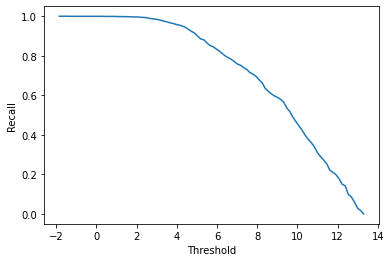

In [9]:
# 获取donor位点序列片段
donor_sequences = get_sequence(training_path, type='positive')

# 计算每个donor位点序列片段的分数
score_list = [donor_score(x, log_score) for x in donor_sequences]
score_array = np.array(score_list)

# 设置不同阈值，计算召回率
thresholds = np.linspace(score_array.min(), score_array.max(), 100)
recall_list = [np.sum(score_array > t) / score_array.shape for t in thresholds]
recall_array = np.array(recall_list).reshape(-1)

# 绘图
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.plot(thresholds, recall_array)

### 进行预测
从验证集中选取一个文件为例。使用上面的阈值和``search_donor_site``函数，对序列中的donor位点进行预测，以确认算法能否正常运行。

可以看出，虽然WAM顺利预测出了序列中存在的donor位点，但是序列中存在大量的假阳性结果。

In [10]:
# 选取一个文件，从中得到序列
file_path = testing_path + '/ACU08131.TXT'

with open(file_path, 'r') as FILE:
    lines = FILE.readlines()
    sequence = ''.join(lines[2:]).replace('\n', '').lower()
    
    # 提取出实际的donor位点
    donor_sites = re.findall('(\d+)(?=,)', lines[1])
    
    # 预测donor位点
    predict_donor_sites = search_donor_site(sequence, log_score, threshold=5)

    print('Actural donor sites: \n[', ', '.join(donor_sites) + ']', sep='')
    print('Predicted donor sites: \n', predict_donor_sites, sep='')

Actural donor sites: 
[641, 1362, 2028, 2802, 3797]
Predicted donor sites: 
[157, 321, 325, 386, 462, 501, 532, 641, 709, 789, 844, 982, 993, 1008, 1023, 1172, 1178, 1229, 1254, 1362, 1602, 1734, 1859, 1981, 2028, 2133, 2211, 2244, 2259, 2349, 2387, 2437, 2456, 2497, 2636, 2676, 2701, 2802, 2806, 2839, 3335, 3557, 3620, 3623, 3797, 3817, 3824, 3913, 3981, 4037, 4166, 4305, 4451, 4503, 4511, 4562, 4865, 4919, 4970, 4991, 5169, 5175, 5312, 5323, 5360]


## 讨论

从验证集中获取阳性donor位点样本和阴性样本，并计算所有样本的分数，用于后续的性能评估。

In [11]:
# 样本的获取
positive_seq = get_sequence(testing_path, type='positive')
negative_seq = get_sequence(testing_path, type='negative')

# 合并成一个列表
test_sample = positive_seq + negative_seq
test_true = [1] * len(positive_seq) + [0] * len(negative_seq)

# 分数的计算
print('Handling samples ...')
test_score = [donor_score(x, log_score) for x in tqdm(test_sample)]

Handling files in '/content/drive/MyDrive/Collab Files/donor_dataset/testing' ...


100%|██████████| 570/570 [00:08<00:00, 66.83it/s] 


Handling files in '/content/drive/MyDrive/Collab Files/donor_dataset/testing' ...


100%|██████████| 570/570 [00:07<00:00, 72.55it/s]


Handling samples ...


100%|██████████| 2885704/2885704 [00:17<00:00, 161302.02it/s]


### ROC曲线与AUC
使用上面得到的样本，绘制ROC曲线，并计算曲线下面积（AUC）。

得到结果为$AUC=0.9966$

AUC = 0.9966129710498344


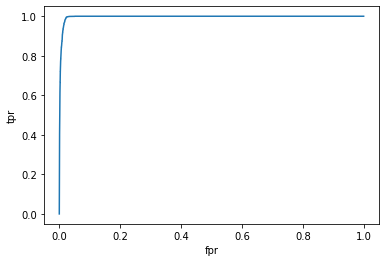

In [12]:
# 计算ROC曲线和AUC
test_score_noinf = [-1000 if x == -np.inf else x for x in test_score]
fpr, tpr, thresholds = roc_curve(test_true, test_score_noinf)
AUC = auc(fpr, tpr)

# 绘图
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot(fpr, tpr)
print('AUC =', AUC)

### F1-score与阈值的关系
在“结果”部分中，注意到使用基于召回率得到的阈值时，结果存在大量的假阳性。因此使用刚才计算出的分数，绘制F1-score与阈值的关系图。

根据先前的召回率计算，将绘图的阈值范围设定在2到13。从图中可以看出，F1-score最大时也未能超过0.35，对应的阈值的召回率已低于0.5。


Calculating F1-score ...


100%|██████████| 100/100 [06:29<00:00,  3.90s/it]


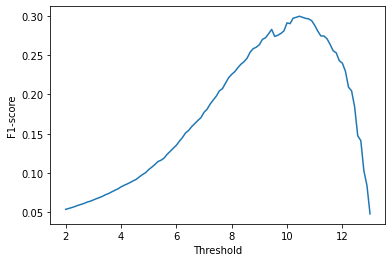

In [13]:
thresholds = np.linspace(2, 13, 100)
F1_list = []

# 设置不同阈值，计算F1-score
print('Calculating F1-score ...')
for t in tqdm(thresholds):
    test_pred = [1 if x > t else 0 for x in test_score]
    F1_list.append(f1_score(test_true, test_pred))

# 绘图
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.plot(thresholds, F1_list)

### 最佳阈值的混淆矩阵
采用F1-score最大时的阈值，作为最佳阈值。并基于最佳阈值计算混淆矩阵。

输出结果中：
* 第一行、第二行对应实际的阴性样本和阳性样本
* 第一列、第二列对应预测的阴性和阳性结果

对应到输出结果中则是：

[[TN    FP]

 [FN    TP]]

In [14]:
# 获取最佳阈值
best_threshold = thresholds[np.argmax(F1_list)]

# 计算混淆矩阵
test_pred = [1 if x > best_threshold else 0 for x in test_score]
conf_matrix = confusion_matrix(test_true, test_pred)

print(conf_matrix)

[[2880979    2646]
 [   1247     832]]


## 结论
虽然WAM模型基于理论上最优性能的贝叶斯判别器，原理简单易懂，易于训练。但是在实际应用中，存在假阳性率过高的问题，且难以选择合理的阈值。至少，基于本次上机能获取的有限的数据，在donor位点识别的任务上，WAM模型的效果并不理想。